In [3]:
import tensorflow as tf
import numpy as np
import os
import ast
import abc
import random
from typing import List, Dict, Union, Tuple
import numpy as np
from scipy.stats import truncnorm
import argparse
import timeit
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
# from tensorflow_addons.layers.nalu import NALU
%load_ext tensorboard

os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # disable cuda sepeed up
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # disable CPU wornings

2022-11-30 11:33:10.211991: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-30 11:33:10.212095: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [15]:
data = np.load("inalu_data_tf1/data.npy")
int_data = np.load("inalu_data_tf1/int_data.npy")
ext_data = np.load("inalu_data_tf1/ext_data.npy")


g = np.load("inalu_data_tf1/g.npy")
w1 = np.load("inalu_data_tf1/w1.npy")
m1 = np.load("inalu_data_tf1/m1.npy")
w2 = np.load("inalu_data_tf1/w2.npy")
m2 = np.load("inalu_data_tf1/m2.npy")


losses = np.load("inalu_data_tf1/flosses.npy")
rlosses = np.load("inalu_data_tf1/frlosses.npy")
ext_loss = np.load("inalu_data_tf1/fext_loss.npy")
int_loss = np.load("inalu_data_tf1/fint_loss.npy")
rext_loss = np.load("inalu_data_tf1/frext_loss.npy")
rint_loss = np.load("inalu_data_tf1/frint_loss.npy")

In [16]:
BATCH_SIZE = 64
operation_arg = "mul"

def operation(op, a, b):
    if op.lower() == "mul":
        return a * b
    if op.lower() == "add":
        return a + b
    if op.lower() == "sub":
        return a - b
    if op.lower() == "div":
        return a / b

lbls = operation(operation_arg, data[:,0], data[:,1])
lbls = np.reshape(lbls, newshape=(-1, 1))

int_lbls = operation(operation_arg, int_data[:,0], int_data[:,1])
int_lbls = np.reshape(int_lbls, newshape=(-1, 1))


ext_lbls = operation(operation_arg, ext_data[:,0], ext_data[:,1])
ext_lbls = np.reshape(ext_lbls, newshape=(-1, 1))

data_dp = tf.data.Dataset.from_tensor_slices((data, lbls)).prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE)
int_data_dp = tf.data.Dataset.from_tensor_slices((int_data, int_lbls)).prefetch(tf.data.AUTOTUNE)
ext_data_dp = tf.data.Dataset.from_tensor_slices((ext_data, ext_lbls)).prefetch(tf.data.AUTOTUNE)

In [19]:
tf.Variable(g, trainable = False, name = "g")

<tf.Variable 'g:0' shape=(1,) dtype=float32, numpy=array([0.04638282], dtype=float32)>

In [20]:
# Copyright 2020 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# =====================================================epoch
import tensorflow as tf
from typeguard import typechecked
from typing import List
from tensorflow_addons.utils import types

tf.keras.backend.clear_session()


class NALURegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, reg_coef=0.1):
        self.reg_coef = reg_coef

    def __call__(self, var: List[tf.Variable]) -> tf.Tensor:
        return self.reg_coef * tf.add_n(
            [
                tf.reduce_mean(tf.math.maximum(tf.math.minimum(-v, v) + 20, 0))
                for v in var
            ]
        )

    def get_config(self):
        return {"reg_coef": float(self.reg_coef)}


# @tf.keras.utils.register_keras_serializable(package="Addons")


class NALU(tf.keras.layers.Layer):


    r"""Neural Arithmetic Logic Units
    A layer that learns addition,substraction, multiplication and division
    in transparent way. They layer has two paths: one for addition/substration
    and one for multiplication/division. We can inspect weights for these two
    paths by calling `w_hat` and `m_hat` respectively. To use this layer reliably,
    we have to delay regularization of gating varaible that switch between two paths.
    Ithave to be done by callback as from the layer-level we keep no information about epochs.
    See [Neural Arithmetic Logic Units](https://arxiv.org/abs/1808.00508)
    and [Improved Neural Arithmetic Logic Unit](https://arxiv.org/abs/2003.07629)
    Example:
    >>> BATCH_SIZE, INPUT_SIZE, OUTPUT_SIZE = 16, 5, 2
    >>> input = tf.random.uniform((BATCH_SIZE, INPUT_SIZE))
    >>> nalu_layer = NALU(OUTPUT_SIZE)
    >>> predict = nalu_layer(input)
    >>> assert predict.shape == (BATCH_SIZE, OUTPUT_SIZE)
    Args:
        input_dim (int): input
        output_dim (int): _description_
        regularizer (types.Regularizer, optional): _description_. Defaults to NALURegularizer(reg_coef=0.05).
        gate_as_vector (bool, optional): _description_. Defaults to True.
        clipping (float, optional): _description_. Defaults to None.
        force_operation (str, optional): _description_. Defaults to None.
        weights_separation (bool, optional): _description_. Defaults to True.
        input_gate_dependance (bool, optional): _description_. Defaults to True.
        w_initializer (types.Initializer, optional): _description_. Defaults to tf.random_normal_initializer( mean=0.88, stddev=0.2, seed=None ).
        m_initializer (types.Initializer, optional): _description_. Defaults to tf.random_normal_initializer( mean=0.5, stddev=0.2, seed=None ).
        g_initializer (types.Initializer, optional): _description_. Defaults to tf.random_normal_initializer( mean=0.0, stddev=0.2, seed=None ).
    """

    class NALUModel(tf.keras.Model):
        """It's super class to create models with NALU layer which controls the training step.
        To speed up we use @tf.function to build graph of computation, but dynamically control
        myst rely on tf.variables as all other attributes are compiled to static values.
        E.g. self.regularize controls when to start regularization and self.gating controls
        when to train gates insted of active varaivles. We can dynamically reassign values 
        to these variables to controll training steps from the callback positions (LoopControll).
        """

        def __init__(self, *args, **kwargs):
            
            super(NALU.NALUModel, self).__init__(*args, **kwargs)
            self.regularize = tf.Variable(False, trainable=False)
            self.gating = tf.Variable(False, trainable=False)
            self.gate_var = None

        def reinitialise(self):
            for l in self.layers:
                if isinstance(l, NALU):
                    l.reinitialise()

        def get_gates_variables(self) -> List[tf.Variable]:
            return [l.g for l in self.layers if isinstance(l, NALU)]

        def get_regularization_loss(self):
            return tf.math.reduce_sum(self.losses)

        @tf.function
        def train_step_active(self, data):
            if not self.gate_var:
                self.gate_var = self.get_gates_variables()
            x, y = data
            with tf.GradientTape() as tape:
                logits = self(x, training=True)
                loss_value = self.compiled_loss(y, logits)
            grads = tape.gradient(loss_value, tape.watched_variables())
            grads = [tf.clip_by_value(g, -0.1, 0.1) for g in grads]
            self.optimizer.apply_gradients(zip(grads, tape.watched_variables()))
            return {**{m.name: m.result() for m in self.metrics}, **{"ll": loss_value}}

        @tf.function
        def train_step_gating(self, data):
            if not self.gate_var:
                self.gate_var = self.get_gates_variables()
            x, y = data
            with tf.GradientTape(watch_accessed_variables=False) as tape:
                for g in self.gate_var:
                    tape.watch(g)

                logits = self(x, training=True)
                loss_value = self.compiled_loss(y, logits)

            grads = tape.gradient(loss_value, tape.watched_variables())
            grads = [tf.clip_by_value(g, -0.1, 0.1) for g in grads]
            self.optimizer.apply_gradients(zip(grads, tape.watched_variables()))
            return {**{m.name: m.result() for m in self.metrics}, **{"ll": loss_value}}

        @tf.function
        def train_step_regularize(self):
            with tf.GradientTape(watch_accessed_variables=True) as tape:
                for g in self.gate_var:
                    tape.watch(g)
                reg_loss = self.get_regularization_loss()
            grads = tape.gradient(reg_loss, tape.watched_variables())
            grads = [tf.clip_by_value(g, -0.1, 0.1) for g in grads]
            self.optimizer.apply_gradients(zip(grads, tape.watched_variables()))
            return reg_loss


            """
            Specifying tf.function(input_signature=...) slows down the computation, but it leads to greater control:
            https://www.neuralconcept.com/post/in-graph-training-loop
            """

        @tf.function
        def train_step(self, data):
            metrics_train = tf.cond(
                self.gating,
                lambda: self.train_step_gating(data),
                lambda: self.train_step_active(data),
            )

            metrics_train["rl"] = tf.cond(
                self.regularize, lambda: self.train_step_regularize(), lambda: 0.0
            )
            return metrics_train

        # @tf.function
        def predict_loss(self, x, y):
            logits = self(x, training=False)
            return self.compiled_loss(y, logits)

            


    class NALUControl(tf.keras.callbacks.Callback):
        """Callback that controll the training loop. It controlls variables of the model that subclass LoopStep so that
        we controll how the trainign loop work still usingn default model.fit(...) functionality. We modify LoopSep-model
        variables values via accessing self.model.__controll_variables__. Using [callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback) 
        functions we controll variables values reasignment from the training-loop level. 
        Args:
            ext_data (types.TensorLike): data to check performance on extrapolation data
            ext_label (types.TensorLike): labels to check performance on extrapolation data
            int_data (types.TensorLike): data to check performance on intrapolation data
            int_label (types.TensorLike): labels to check performance on extrapolation data
            regularization_delay (int, optional): number of epochs after which regularization starts (if loss is smaller thatn regularization_loss_threshold). Defaults to 8.
            regularization_loss_threshold (float, optional): loss threshold below which regularization starts (if number of epochs is greater than regularization_delay). Defaults to 1.0.
            param_check (int, optional): number of steps after which performance on extra/inter-polation data is calculated. Results can be accessed by ext-res and int-res, respectively. Defaults to 10000.
        """

        @typechecked
        def __init__(
            self,
            ext_data: types.TensorLike,
            ext_label: types.TensorLike,
            int_data: types.TensorLike,
            int_label: types.TensorLike,
            regularization_delay: int = 8,
            regularization_loss_threshold: float = 1.0,
            param_check: int = 10000,
            *args,
            **kwargs,
        ):


            super(NALU.NALUControl, self).__init__(*args, **kwargs)
            NALU.NALUControl.regularization_delay = regularization_delay
            NALU.NALUControl.regularization_loss_threshold = regularization_loss_threshold
            NALU.NALUControl.param_check = param_check
            self.ext_data = ext_data
            self.ext_label = ext_label
            self.int_data = int_data
            self.int_label = int_label

        def on_train_begin(self, logs=None):
            NALU.NALUControl.reinit_history = [] # history after recent reinit
            NALU.NALUControl.reinit_counter = 0 # reinitialization counter
            NALU.NALUControl._steps_counter = 0 # global step counter
            NALU.NALUControl._epoch_counter = 0 # global epoch counter
            NALU.NALUControl.ext_res = [] # extrapolation data evaluation
            NALU.NALUControl.int_res = [] # interpolation data evaluation

        def on_epoch_end(self, epoch, logs=None):
            NALU.NALUControl._epoch_counter += 1

        def on_train_batch_end(self, batch, logs=None):

            # increment global step counter 
            NALU.NALUControl._steps_counter += 1

            # record last loss
            NALU.NALUControl.reinit_history.append(logs.get("loss"))

            # train either active or gating
            self.model.gating.assign(NALU.NALUControl._steps_counter % 10 > 8)

            # turn on or of ragularization depending on epoch number and last seen loss
            self.model.regularize.assign(
                NALU.NALUControl._epoch_counter >= NALU.NALUControl.regularization_delay and
                NALU.NALUControl.reinit_history[-1] < NALU.NALUControl.regularization_loss_threshold
            )

            # reinitialisation strategy
            split_index = len(NALU.NALUControl.reinit_history) // 2
            if (
                len(NALU.NALUControl.reinit_history) > 10000
                and NALU.NALUControl._epoch_counter > 0
                and NALU.NALUControl._epoch_counter % 10 == 1
                and tf.math.reduce_mean(NALU.NALUControl.reinit_history[:split_index])
                <= tf.math.add(
                    tf.math.reduce_mean(NALU.NALUControl.reinit_history[split_index:]),
                    tf.math.reduce_std(NALU.NALUControl.reinit_history[split_index:]),
                )
                and tf.math.reduce_mean(NALU.NALUControl.reinit_history[split_index:])
                > 1
            ):
                # reinitialize all nalu layers
                self.model.reinitialise()
                NALU.NALUControl.reinit_history = [] # clear recent history
                NALU.NALUControl.reinit_counter += 1 # increment 

            # check parameters
            if self._steps_counter % NALU.NALUControl.param_check == 0:
                eloss_ex = self.model.compiled_loss._losses[0](
                    self.model.predict(self.ext_data, verbose=0), self.ext_label
                )
                eloss_in = self.model.compiled_loss._losses[0](
                    self.model.predict(self.int_data, verbose=0), self.int_label
                )
                NALU.NALUControl.ext_res.append(eloss_ex)
                NALU.NALUControl.int_res.append(eloss_in)

    @typechecked
    def __init__(
        self,
        units: int,
        regularizer: types.Regularizer = NALURegularizer(reg_coef=0.05),
        clipping: float = 20,
        w_initializer: types.Initializer = tf.random_normal_initializer(
            mean=1.0, stddev=0.1, seed=None
        ),
        m_initializer: types.Initializer = tf.random_normal_initializer(
            mean=-1.0, stddev=0.1, seed=None
        ),
        g_initializer: types.Initializer = tf.random_normal_initializer(
            mean=0.0, stddev=0.1, seed=None
        ),
        *args,
        **kwargs,
    ):
        super(NALU, self).__init__(*args, **kwargs)

        self.units = units
        self.reg_fn = regularizer
        self.clipping = clipping
        
        self.w_initializer = w_initializer
        self.m_initializer = m_initializer
        self.g_initializer = g_initializer

        self.gate_as_vector = True
        self.force_operation = None
        self.weights_separation = True
        self.input_gate_dependance = False
        self.initializer = None

        # action variables
        self.w_hat = tf.Variable(
            w1,
            trainable = True,
            name = "w",
        )

        self.m_hat = tf.Variable(
            m1,
            trainable = True,
            name = "m",
        )

        self.w_hat_prime = tf.Variable(
            w2,
            trainable = True,
            name = "w_prime"
        )

        self.m_hat_prime = tf.Variable(
            m2,
            trainable = True,
            name = "m_prime"
        )

        # gating varaible
        self.g = tf.Variable(
            g,
            trainable = False,
            name = "g"
        )



    # def build(self, input_shape):
        
    #     # action variables
    #     self.w_hat = self.add_weight (
    #         shape = (input_shape[-1], self.units),
    #         initializer = self.w_initializer,
    #         trainable = True,
    #         name = "w",
    #         use_resource = False
    #     )

    #     self.m_hat = self.add_weight (
    #         shape = (input_shape[-1], self.units),
    #         initializer = self.m_initializer,
    #         trainable = True,
    #         name = "m",
    #         use_resource = False
    #     )

    #     self.w_hat_prime = self.add_weight (
    #         shape = (input_shape[-1], self.units),
    #         initializer = self.w_initializer,
    #         trainable = True,
    #         name = "w_prime",
    #         use_resource = False
    #     )

    #     self.m_hat_prime = self.add_weight (
    #         shape = (input_shape[-1], self.units),
    #         initializer = self.m_initializer,
    #         trainable = True,
    #         name = "m_prime",
    #         use_resource = False
    #     )

    #     # gating varaible
    #     self.g = self.add_weight (
    #         shape = (self.units, ),
    #         initializer = self.g_initializer,
    #         trainable = False,
    #         name = "g",
    #         use_resource = False
    #     )


    @tf.function
    def get_reg_loss(self):
        var_list = [self.w_hat, self.m_hat, self.g]
        if self.weights_separation:
            var_list += [self.w_hat_prime, self.m_hat_prime]
        return self.reg_fn(var_list)

    def call(self, input):
        eps = 1e-7
        w1 = tf.math.tanh(self.w_hat) * tf.math.sigmoid(self.m_hat)
        w2 = tf.math.tanh(self.w_hat_prime) * tf.math.sigmoid(self.m_hat_prime)
        a1 = tf.matmul(input, w1)

        m1 = tf.math.exp(tf.minimum(tf.matmul(tf.math.log(tf.maximum(tf.math.abs(input), eps)),w2), self.clipping))
        
        # sign
        w1s = tf.math.abs(tf.reshape(w2, [-1]))
        xs = tf.concat([input] * w1.shape[1], axis=1)
        xs = tf.reshape(xs, shape=[-1, w1.shape[0] * w1.shape[1]])
        sgn = tf.sign(xs) * w1s + (1 - w1s)
        sgn = tf.reshape(sgn, shape=[-1, w1.shape[1], w1.shape[0]])
        ms = tf.math.reduce_prod(sgn, axis=2)
        
        self.add_loss(lambda: self.get_reg_loss())

        g1 = tf.math.sigmoid(self.g)
        return g1 * a1 + (1 - g1) * m1 * tf.clip_by_value(ms, -1, 1)

    def reinitialise(self):
        self.g.assign(tf.random.uniform(self.g.shape, -2, 2))
        self.w_hat.assign(tf.random.uniform(self.w_hat.shape, -2, 2))
        self.m_hat.assign(tf.random.uniform(self.m_hat.shape, -2, 2))
        if self.weights_separation:
            self.w_hat_prime.assign(tf.random.uniform(self.w_hat_prime.shape, -2, 2))
            self.m_hat_prime.assign(tf.random.uniform(self.m_hat_prime.shape, -2, 2))

    def get_gates_variables(self) -> List[tf.Variable]:
        return [self.g]

In [116]:
tf.keras.backend.clear_session()
tf.keras.backend.set_learning_phase(0)

class NALUModel(NALU.NALUModel):

    def __init__(self, *args, **kwargs):
        super(NALUModel, self).__init__(*args, **kwargs)

        self.layer1 = NALU(1,
            clipping = 20
            )
    
    def call(self, inputs: tf.Tensor):
        return self.layer1(inputs)

# define model
model = NALUModel()

# first dummy pass to build variables
#_ = model(next(iter(data_dp))[0])

# compile model
model.compile(optimizer=
    tf.keras.optimizers.RMSprop(learning_rate=0.01),
    loss="mse", 
    metrics=["mae"])

# start training
history = model.fit(data_dp, 
    batch_size = 64, epochs = 20, 
    callbacks=[NALU.NALUControl(
        ext_data, ext_lbls, 
        int_data, int_lbls, 
        regularization_delay = 11, 
        param_check = 1000)
    ])

Epoch 1/20


/home/filip/workspace/tf/venv/lib/python3.8/site-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


1000/1000 [==============================] - 11s 8ms/step - loss: 0.3392 - ll: 0.3389 - rl: 0.0000e+00
Epoch 2/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0449 - ll: 0.0449 - rl: 0.0000e+00
Epoch 3/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0109 - ll: 0.0109 - rl: 0.0000e+00
Epoch 4/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0025 - ll: 0.0024 - rl: 0.0000e+00
Epoch 5/20
1000/1000 [==============================] - 8s 8ms/step - loss: 5.2373e-04 - ll: 5.2338e-04 - rl: 0.0000e+00
Epoch 6/20
1000/1000 [==============================] - 8s 8ms/step - loss: 1.0929e-04 - ll: 1.0921e-04 - rl: 0.0000e+00
Epoch 7/20
1000/1000 [==============================] - 8s 8ms/step - loss: 2.2580e-05 - ll: 2.2565e-05 - rl: 0.0000e+00
Epoch 8/20
1000/1000 [==============================] - 8s 8ms/step - loss: 4.6643e-06 - ll: 4.6612e-06 - rl: 0.0000e+00
Epoch 9/20
1000/1000 [==============================] - 8s 8ms/step - loss

In [172]:
# define model
model = NALUModel()

# first dummy pass to build variables
_ = model(next(iter(data_dp))[0])

# compile model
model.compile(optimizer=
    tf.keras.optimizers.RMSprop(learning_rate=0.01),
    loss="mse", 
    metrics=["mae"])

losses_ = []
rlosses_ = []
ext_loss_ = []
int_loss_ = []
rext_loss_ = []
rint_loss_ = []


batch_size = 64

for epoch in range(20):
    print(epoch)
    i = 0
    for data in data_dp:
        if (i // batch_size) % 10 < 8:
            metrics = model.train_step_active(data) # model.gating.assign(False)
        else:
            metrics = model.train_step_gating(data)
        
        losses_.append(metrics["ll"])

        if epoch > 10:
            model.train_step_regularize()
        
        if "rl" not in metrics:
            rlosses_.append(0)
        else:
            rlosses_.append(metrics["rl"])
        i+=batch_size

        if (i // batch_size) % 1000 == 0:
            eloss_ex = model.compiled_loss._losses[0](
                model.predict(ext_data, verbose=0), ext_lbls
            )
            eloss_in = model.compiled_loss._losses[0](
                model.predict(int_data, verbose=0), int_lbls
            )
            ext_loss_.append(eloss_ex)
            int_loss_.append(eloss_in)

losses_ = list(map(lambda x : x.numpy(), losses_))
#rlosses_ = list(map(lambda x : x.numpy(), rlosses_))
ext_loss_ = list(map(lambda x: x.numpy(), ext_loss_))
int_loss_ = list(map(lambda x: x.numpy(), int_loss_))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Text(0.5, 1.0, 'Training Loss Comarison')

<Figure size 432x288 with 0 Axes>

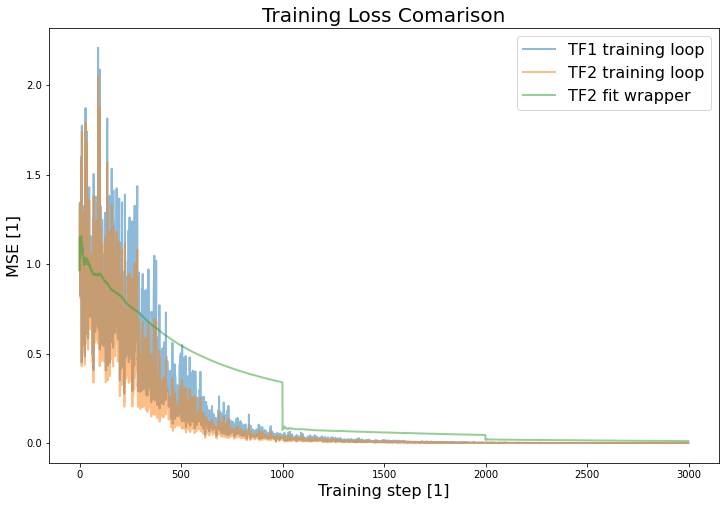

In [170]:
steps = 3000
#
plt.figure(figsize= tuple(map(lambda x: 2*x, plt.gcf().get_size_inches())))
# plt.margins(0)
line_width = 2.0
plt.plot(losses[:steps], label = "TF1 training loop", alpha=0.5, linewidth=line_width)
plt.plot(losses_[:steps], label = "TF2 training loop", alpha=0.5, linewidth=line_width)
plt.plot(NALU.NALUControl.reinit_history[:steps], label = "TF2 fit wrapper", alpha=0.5, linewidth=line_width)
leg = plt.legend(prop={'size': 16})
for line in leg.get_lines():
    line.set_linewidth(line_width)

plt.ylabel("MSE [1]", fontsize=16)
plt.xlabel("Training step [1]", fontsize=16)
# ax2 = plt.twiny()
# ax2.set_xticks(np.arange(steps//1000 + 1))
# ax2.set_xlabel("Epochs [1]", fontsize = 16)

plt.title("Training Loss Comarison", fontsize=20)
#plt.savefig("loss.jpg")
#plt.savefig("loss.png")


Text(0.5, 1.0, 'Training Loss Comarison in Log Scale')

<Figure size 432x288 with 0 Axes>

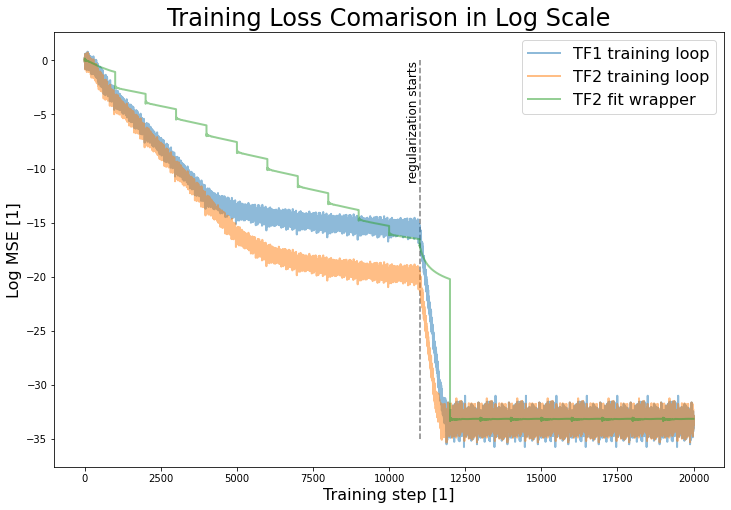

In [171]:
plt.figure(figsize= tuple(map(lambda x: 2*x, plt.gcf().get_size_inches())))
# plt.margins(0)
plt.vlines(x=11000, ymin=-35, ymax=0, colors="black", alpha = 0.5, linestyles = "dashed")
plt.text(11000, 0, "regularization starts", rotation=90, verticalalignment='top', horizontalalignment="right", fontsize = 12)
line_width = 2.0
plt.plot(np.log(losses), label = "TF1 training loop", alpha=0.5, linewidth=line_width)
plt.plot(np.log(losses_), label = "TF2 training loop", alpha=0.5, linewidth=line_width)
plt.plot(np.log(NALU.NALUControl.reinit_history), label = "TF2 fit wrapper", alpha=0.5, linewidth=line_width)

leg = plt.legend(prop={'size': 16})
for line in leg.get_lines():
    line.set_linewidth(line_width)

plt.ylabel("Log MSE [1]", fontsize=16)
plt.xlabel("Training step [1]", fontsize=16)
# ax2 = plt.twiny()
# ax2.set_xticks(np.arange(20))
# ax2.set_xlabel("Epochs [1]", fontsize = 16)
plt.title("Training Loss Comarison in Log Scale", fontsize=24)
#plt.savefig("log_loss.jpg")
#plt.savefig("log_loss.png")

<Figure size 432x288 with 0 Axes>

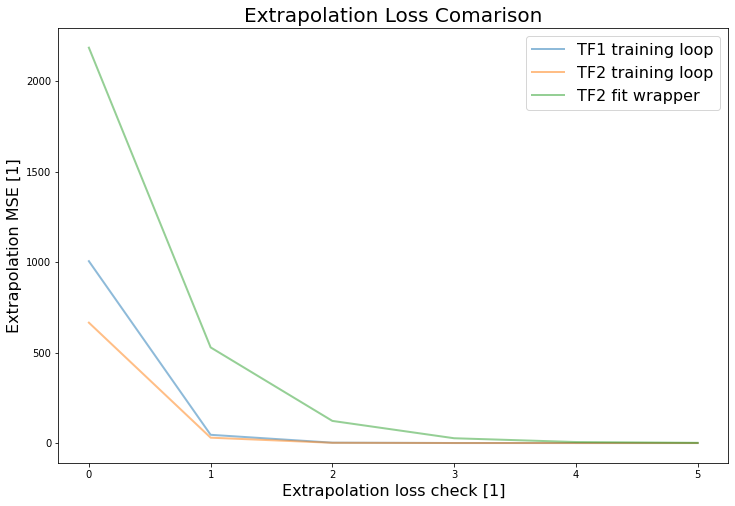

In [154]:
plt.figure(figsize= tuple(map(lambda x: 2*x, plt.gcf().get_size_inches())))
steps = 6
line_width = 2.0
plt.plot(ext_loss[:steps], label = "TF1 training loop", alpha=0.5, linewidth=line_width)
plt.plot(ext_loss_[:steps], label = "TF2 training loop", alpha=0.5, linewidth=line_width)
plt.plot(NALU.NALUControl.ext_res[:steps], label = "TF2 fit wrapper", alpha=0.5, linewidth=line_width)
leg = plt.legend(prop={'size': 16})
for line in leg.get_lines():
    line.set_linewidth(line_width)

plt.ylabel("Extrapolation MSE [1]", fontsize=16)
plt.xlabel("Extrapolation loss check [1]", fontsize=16)
plt.title("Extrapolation Loss Comarison", fontsize=20)
plt.savefig("ext_loss.png")

<Figure size 432x288 with 0 Axes>

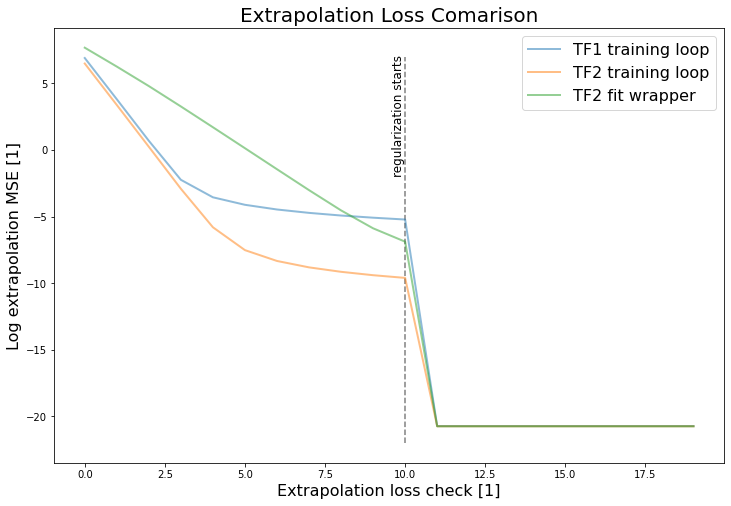

In [155]:
plt.figure(figsize= tuple(map(lambda x: 2*x, plt.gcf().get_size_inches())))
steps = 20
line_width = 2.0
plt.vlines(x=10, ymin=-22, ymax=7, colors="black", alpha = 0.5, linestyles = "dashed")
plt.text(10, -2, "regularization starts", rotation=90, verticalalignment='bottom', horizontalalignment="right", fontsize = 12)
plt.plot(np.log(ext_loss[:steps]), label = "TF1 training loop", alpha=0.5, linewidth=line_width)
plt.plot(np.log(ext_loss_[:steps]), label = "TF2 training loop", alpha=0.5, linewidth=line_width)
plt.plot(np.log(NALU.NALUControl.ext_res[:steps]), label = "TF2 fit wrapper", alpha=0.5, linewidth=line_width)
leg = plt.legend(prop={'size': 16})
for line in leg.get_lines():
    line.set_linewidth(line_width)

plt.ylabel("Log extrapolation MSE [1]", fontsize=16)
plt.xlabel("Extrapolation loss check [1]", fontsize=16)
plt.title("Extrapolation Loss Comarison", fontsize=20)
plt.savefig("ext_log_loss.png")

<Figure size 432x288 with 0 Axes>

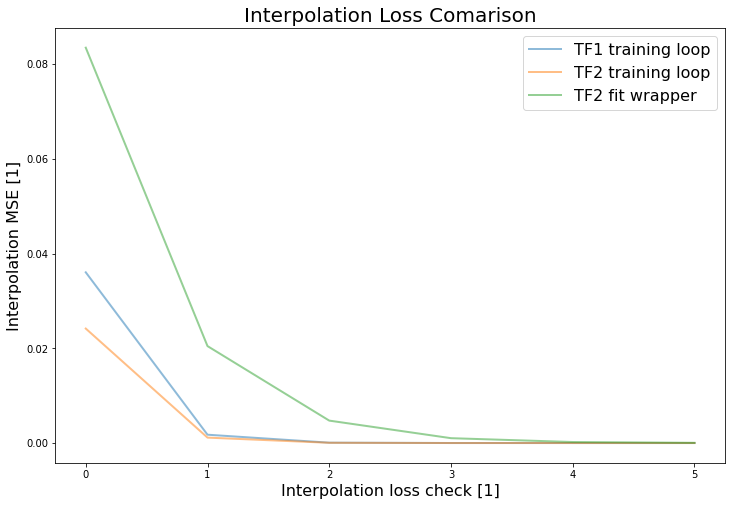

In [156]:
plt.figure(figsize= tuple(map(lambda x: 2*x, plt.gcf().get_size_inches())))
steps = 6
line_width = 2.0
plt.plot(int_loss[:steps], label = "TF1 training loop", alpha=0.5, linewidth=line_width)
plt.plot(int_loss_[:steps], label = "TF2 training loop", alpha=0.5, linewidth=line_width)
plt.plot(NALU.NALUControl.int_res[:steps], label = "TF2 fit wrapper", alpha=0.5, linewidth=line_width)
leg = plt.legend(prop={'size': 16})
for line in leg.get_lines():
    line.set_linewidth(line_width)

plt.ylabel("Interpolation MSE [1]", fontsize=16)
plt.xlabel("Interpolation loss check [1]", fontsize=16)
plt.title("Interpolation Loss Comarison", fontsize=20)
plt.savefig("int_loss.png")

<Figure size 432x288 with 0 Axes>

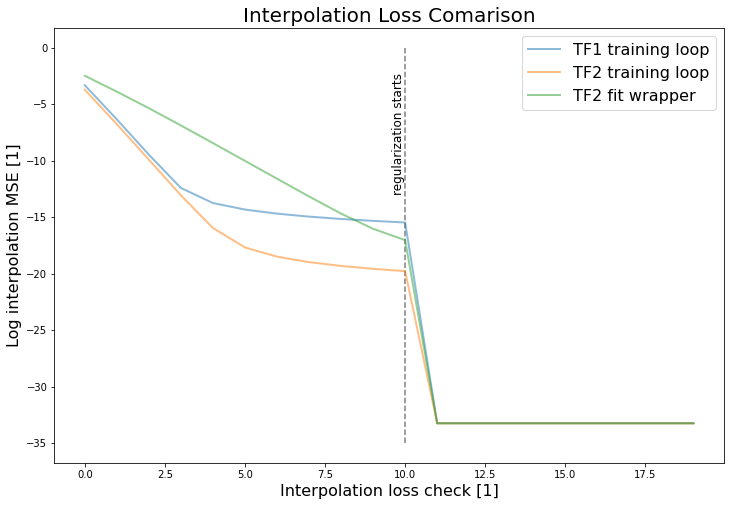

In [157]:
plt.figure(figsize= tuple(map(lambda x: 2*x, plt.gcf().get_size_inches())))
steps = 20
line_width = 2.0
plt.vlines(x=10, ymin=-35, ymax=0, colors="black", alpha = 0.5, linestyles = "dashed")
plt.text(10, -13, "regularization starts", rotation=90, verticalalignment='bottom', horizontalalignment="right", fontsize = 12)
plt.plot(np.log(int_loss[:steps]), label = "TF1 training loop", alpha=0.5, linewidth=line_width)
plt.plot(np.log(int_loss_[:steps]), label = "TF2 training loop", alpha=0.5, linewidth=line_width)
plt.plot(np.log(NALU.NALUControl.int_res[:steps]), label = "TF2 fit wrapper", alpha=0.5, linewidth=line_width)
leg = plt.legend(prop={'size': 16})
for line in leg.get_lines():
    line.set_linewidth(line_width)

plt.ylabel("Log interpolation MSE [1]", fontsize=16)
plt.xlabel("Interpolation loss check [1]", fontsize=16)
plt.title("Interpolation Loss Comarison", fontsize=20)
plt.savefig("int_log_loss.png")

In [65]:
import time
def test1():
    tf.keras.backend.clear_session()
    tf.keras.backend.set_learning_phase(0)

    class NALUModel(NALU.LoopStep):

        def __init__(self, *args, **kwargs):
            super(NALUModel, self).__init__(*args, **kwargs)

            self.layer1 = NALU(1,
                clipping = 20
                )
            # self.layer2 = NALU(1,
            #     clipping = 20
            #     )
            
        def call(self, inputs: tf.Tensor, training: bool = True):
            #return self.layer2(self.layer1(inputs))
            return self.layer1(inputs)

    # tf.keras.backend.clear_session()
    model = NALUModel()
    _ = model(next(iter(data_dp))[0])
    # model.build(next(iter(data_dp))[0].shape[-1])
    model.compile(optimizer=
        tf.keras.optimizers.RMSprop(learning_rate=0.01), #, epsilon = 1e-10), 
        loss="mse", 
        metrics=["mae"])
    st = time.time()
    _ = model.train_step_active(next(iter(data_dp)))
    et = time.time()
    compile_time_active = et - st
    # repeat = 10
    # for _ in range(repeat):
    #     st = time.time()
    #     _ = model.train_step_active(next(iter(data_dp)))
    #     et = time.time()
    
    # step_active = (et-st)/repeat

    st = time.time()
    _ = model.train_step_gating(next(iter(data_dp)))
    et = time.time()
    compile_time_gating = et - st
    # repeat = 10
    # for _ in range(repeat):
    #     st = time.time()
    #     _ = model.train_step_gating(next(iter(data_dp)))
    #     et = time.time()
    
    # step_gating = (et-st)/repeat
    

    st = time.time()
    _ = model.train_step(next(iter(data_dp)))
    et = time.time()
    compile_step = et - st
    # repeat = 10
    # for _ in range(repeat):
    #     st = time.time()
    #     _ = model.train_step_gating(next(iter(data_dp)))
    #     et = time.time()
    
    # step = (et-st)/repeat

    return compile_time_active, compile_time_gating, compile_step

res = [test1() for _ in range(10)]

0.2605438232421875